Import libraries

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GroupShuffleSplit
from jupyter_datatables import init_datatables_mode

Readind data and EDA

In [2]:
data = pd.read_csv(
    r"C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TrainingSet_20aimVO.csv")


In [3]:
data['patient'] = data['image_filename'].apply(lambda x: int(x.split('_')[2].split('.')[0]))

In [4]:
data['image_filename'] = data['image_filename'].astype(str)


In [5]:
data.head()

,image_filename,class_number,patient
0,im_4_0.png,0,0
1,im_21_0.png,0,0
2,im_9_0.png,0,0
3,im_8_0.png,0,0
4,im_15_0.png,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9446 entries, 0 to 9445
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  9446 non-null   object
 1   class_number    9446 non-null   int64 
 2   patient         9446 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 221.5+ KB


In [7]:
images_per_label = data['class_number'].value_counts()

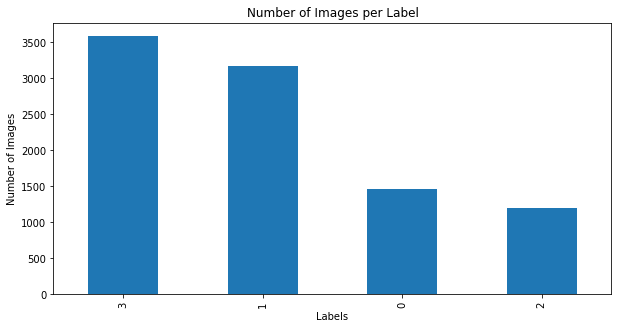

In [8]:
images_per_label.plot(kind='bar', x='patient', y='counts', figsize=(10, 5))
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.show()


In [9]:
images_per_patient = data.groupby('patient').size().reset_index(name='counts')

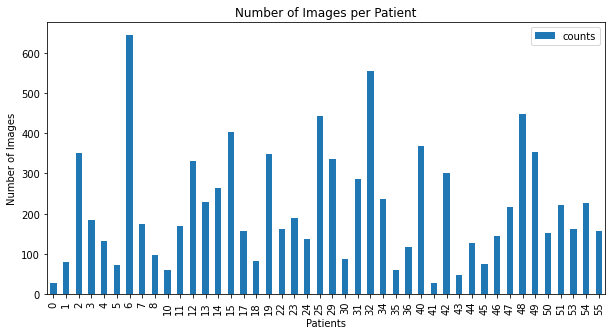

In [10]:
images_per_patient.plot(kind='bar', x='patient', y='counts', figsize=(10,5))
plt.xlabel('Patients')
plt.ylabel('Number of Images')
plt.title('Number of Images per Patient')
plt.show()

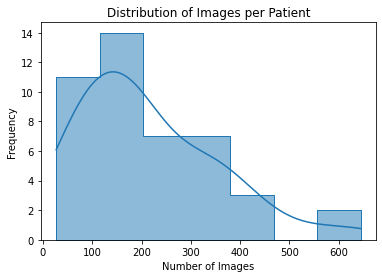

In [11]:
sns.histplot(data=images_per_patient, x='counts', element='step',
             kde=True, bins='auto')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Distribution of Images per Patient')
plt.show()


In [12]:
images_per_patient_label = data.groupby(['patient', 'class_number']).size().reset_index(name='counts')

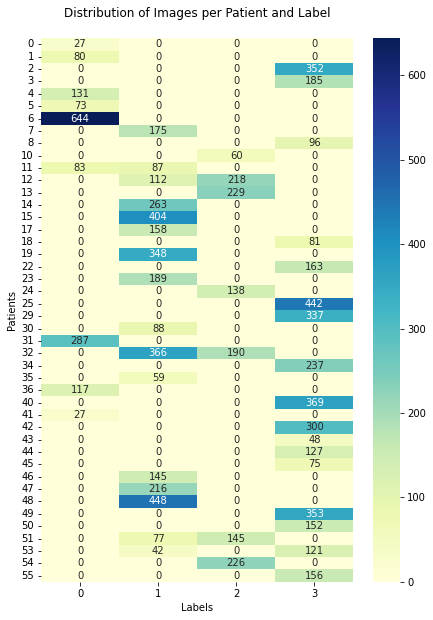

In [13]:
pivoted = images_per_patient_label.pivot_table(
    values='counts', index='patient', columns='class_number', fill_value=0)
fig, ax = plt.subplots(figsize=(7, 10))
sns.heatmap(data=pivoted, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Labels')
plt.ylabel('Patients')
plt.title('Distribution of Images per Patient and Label\n')
plt.show()

In [14]:
images_per_patient_label_nunique = data.groupby(
    ['patient']).class_number.nunique().reset_index(name='counts')
more_than_one_label = pivoted.apply(
    lambda x: x.where(x > 0).count() > 1, axis=1)
count_more_than_one_label = more_than_one_label.sum()
print(f'Patients with images in more than one label: {count_more_than_one_label}')

Patients with images in more than one label: 5


In [15]:
REAL_DIR=r'C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\TrainingSetImagesDir'
TARGET_DIR=r'C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\ClassifiedImages'

In [16]:
split = 0.2

Image Splitting considering that all the images of one patient must be in train folder or validation folder

In [17]:
# # shuffle the dataframe
# perm = np.random.permutation(data.index)
# data = data.iloc[perm]

# # create the split object
# gss = GroupShuffleSplit(n_splits=1, test_size=split, random_state=0)

# # split the data into train and validation sets
# train_index, val_index = next(gss.split(data, groups=data['patient']))

# # get the training and validation data
# df_train = data.iloc[train_index]
# df_val = data.iloc[val_index]

# # loop through the training data and move the images to the train directory
# t=0
# for i, row in df_train.iterrows():
#     label = row['class_number']
#     label_dir = os.path.join(TARGET_DIR, 'Train', str(label))
#     if not os.path.exists(label_dir):
#         os.makedirs(label_dir) # creates directory
#     img_path = os.path.join(REAL_DIR, row['image_filename'])
#     shutil.copy2(img_path, label_dir)
#     t += 1

# # loop through the validation data and move the images to the val directory
# v = 0
# for i, row in df_val.iterrows():
#     label = row['class_number']
#     label_dir = os.path.join(TARGET_DIR,'Val', str(label))
#     if not os.path.exists(label_dir):
#         os.makedirs(label_dir) 
#     img_path = os.path.join(REAL_DIR, row['image_filename'])
#     shutil.copy2(img_path, label_dir)
#     v += 1

# print(f'Total files moved {t+v}')

Image Splitting considering that all the images of one patient must be in train folder or validation folder and patients with multiple labels images

In [18]:
# shuffle the dataframe
perm = np.random.permutation(data.index)
data = data.iloc[perm]

# Create a list to store the dataframes
data_by_label = []

# loop through each label and create a dataframe for that label
for label in range(4):
    data_by_label.append(data[data['class_number'] == label])

# create the split object
gss = GroupShuffleSplit(n_splits=1, test_size=split, random_state=0)

# loop through each dataframe and split the data into train and validation sets
data_train_by_label = []
data_val_by_label = []

for data_label in data_by_label:
    train_index, val_index = next(
        gss.split(data_label, groups=data_label['patient']))
    data_train_by_label.append(data_label.iloc[train_index])
    data_val_by_label.append(data_label.iloc[val_index])

# create a list of directories for the train and validation sets
train_dirs = []
val_dirs = []
for label in range(4):
    train_dirs.append(os.path.join(TARGET_DIR, 'Train', str(label)))
    val_dirs.append(os.path.join(TARGET_DIR, 'Val', str(label)))

# create the directories if they don't exist
for train_dir, val_dir in zip(train_dirs, val_dirs):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)


t = 0
v = 0
for data_train, data_val, train_dir, val_dir in zip(data_train_by_label, data_val_by_label, train_dirs, val_dirs):
    # loop through the training data and move the images to the train directory
    for _, row in data_train.iterrows():
        label = row['class_number']
        label_dir = os.path.join(TARGET_DIR,'Train', str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        img_path = os.path.join(REAL_DIR, row['image_filename'])
        shutil.copy2(img_path, label_dir)
        t += 1
    # loop through the validation data and move the images to the train directory
    for _, row in data_val.iterrows():
        label = row['class_number']
        label_dir = os.path.join(TARGET_DIR, 'Val', str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        img_path = os.path.join(REAL_DIR, row['image_filename'])
        shutil.copy2(img_path, label_dir)
        v += 1

print(f'Total files moved {t+v}')

Total files moved 9446


Check

In [19]:
path_train = r'C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\ClassifiedImages\Train'
path_val = r'C:\Users\conte\OneDrive\Escritorio\Colegio Bourbaki\DL\RedesConvolucionales\Mauna_Kea\MultiClassifier\ClassifiedImages\Val'
labels = [0, 1, 2, 3]
for label in labels:
    counter_train = Counter(os.listdir(os.path.join(path_train, str(label))))
    counter_val = Counter(os.listdir(os.path.join(path_val, str(label))))
    common_elements = counter_train & counter_val
    print(f'Label {label} has {len(common_elements)} common elements')
    print(f'Label {label} in Train has {len(counter_train)} elements')
    print(f'Label {label} in Val has {len(counter_val)} elements')
    split_ratio = len(counter_train) / (len(counter_train) + len(counter_val))
    print(f'Label {label} has a {split_ratio:.3f} split-ratio')
    print('================================================')


Label 0 has 401 common elements
Label 0 in Train has 1469 elements
Label 0 in Val has 401 elements
Label 0 has a 0.786 split-ratio
Label 1 has 881 common elements
Label 1 in Train has 2723 elements
Label 1 in Val has 1335 elements
Label 1 has a 0.671 split-ratio
Label 2 has 1001 common elements
Label 2 in Train has 1206 elements
Label 2 in Val has 1001 elements
Label 2 has a 0.546 split-ratio
Label 3 has 1861 common elements
Label 3 in Train has 3594 elements
Label 3 in Val has 1861 elements
Label 3 has a 0.659 split-ratio
